In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
from jax_lensing.inversion import ks93inv

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

#from jax_lensing.models.convdae import UResNet, SmallUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
dataset = "kappatng"
weight_dir = "../weights/gp-no_sn"
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2

In [5]:
rng_seq = hk.PRNGSequence(42)

In [6]:
#import jax
#import jax.numpy as jnp
#import haiku as hk

#import types
from typing import Mapping, Optional, Sequence, Union

def check_length(length, value, name):
  if len(value) != length:
    raise ValueError(f"`{name}` must be of length 4 not {len(value)}")

class BlockV1(hk.Module):
  """ResNet V1 block with optional bottleneck."""

  def __init__(
      self,
      channels: int,
      stride: Union[int, Sequence[int]],
      use_projection: bool,
      bn_config: Mapping[str, float],
      bottleneck: bool,
      transpose: bool = False,
      name: Optional[str] = None
  ):
    super().__init__(name=name)
    self.use_projection = use_projection

    bn_config = dict(bn_config)
    bn_config.setdefault("create_scale", True)
    bn_config.setdefault("create_offset", True)
    bn_config.setdefault("decay_rate", 0.999)

    if transpose:
      maybe_transposed_conv = hk.Conv2DTranspose
    else:
      maybe_transposed_conv = hk.Conv2D

    if self.use_projection:
      self.proj_conv = maybe_transposed_conv(
          output_channels=channels,
          kernel_shape=1,
          stride=stride,
          with_bias=False,
          padding="SAME",
          name="shortcut_conv")

      self.proj_batchnorm = hk.BatchNorm(name="shortcut_batchnorm", **bn_config)

    channel_div = 4 if bottleneck else 1
    conv_0 = hk.Conv2D(
        output_channels=channels // channel_div,
        kernel_shape=1 if bottleneck else 3,
        stride=1,
        with_bias=False,
        padding="SAME",
        name="conv_0")
    bn_0 = hk.BatchNorm(name="batchnorm_0", **bn_config)

    conv_1 = maybe_transposed_conv(
        output_channels=channels // channel_div,
        kernel_shape=3,
        stride=stride,
        with_bias=False,
        padding="SAME",
        name="conv_1")

    bn_1 = hk.BatchNorm(name="batchnorm_1", **bn_config)
    layers = ((conv_0, bn_0), (conv_1, bn_1))

    if bottleneck:
      conv_2 = hk.Conv2D(
          output_channels=channels,
          kernel_shape=1,
          stride=1,
          with_bias=False,
          padding="SAME",
          name="conv_2")

      bn_2 = hk.BatchNorm(name="batchnorm_2", scale_init=jnp.zeros, **bn_config)
      layers = layers + ((conv_2, bn_2),)

    self.layers = layers

  def __call__(self, inputs, is_training, test_local_stats):
    out = shortcut = inputs

    if self.use_projection:
      shortcut = self.proj_conv(shortcut)
      shortcut = self.proj_batchnorm(shortcut, is_training, test_local_stats)

    for i, (conv_i, bn_i) in enumerate(self.layers):
      out = conv_i(out)
      out = bn_i(out, is_training, test_local_stats)
      if i < len(self.layers) - 1:  # Don't apply relu on last layer
        out = jax.nn.relu(out)

    return jax.nn.relu(out + shortcut)

class BlockGroup(hk.Module):
  """Higher level block for ResNet implementation."""

  def __init__(
      self,
      channels: int,
      num_blocks: int,
      stride: Union[int, Sequence[int]],
      bn_config: Mapping[str, float],
      bottleneck: bool,
      use_projection: bool,
      transpose: bool,
      name: Optional[str] = None,
  ):
    super().__init__(name=name)

    block_cls = BlockV1

    self.blocks = []
    for i in range(num_blocks):
      self.blocks.append(
          block_cls(channels=channels,
                    stride=(1 if i else stride),
                    use_projection=(i == 0 and use_projection),
                    bottleneck=bottleneck,
                    bn_config=bn_config,
                    transpose=transpose,
                    name="block_%d" % (i)))

  def __call__(self, inputs, is_training, test_local_stats):
    out = inputs
    for block in self.blocks:
      out = block(out, is_training, test_local_stats)
    return out


class UResNet(hk.Module):
  """ Implementation of a denoising auto-encoder based on a resnet architecture
  """

  def __init__(self,
               blocks_per_group,
               bn_config,
               bottleneck,
               channels_per_group,
               use_projection,
               name=None):
    """Constructs a Residual UNet model based on a traditional ResNet.
    Args:
      blocks_per_group: A sequence of length 4 that indicates the number of
        blocks created in each group.
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers. By default the
        ``decay_rate`` is ``0.9`` and ``eps`` is ``1e-5``.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults to
        ``False``.
      bottleneck: Whether the block should bottleneck or not. Defaults to
        ``True``.
      channels_per_group: A sequence of length 4 that indicates the number
        of channels used for each block in each group.
      use_projection: A sequence of length 4 that indicates whether each
        residual block should use projection.
      name: Name of the module.
    """
    super().__init__(name=name)
    self.resnet_v2 = False

    bn_config = dict(bn_config or {})
    bn_config.setdefault("decay_rate", 0.9)
    bn_config.setdefault("eps", 1e-5)
    bn_config.setdefault("create_scale", True)
    bn_config.setdefault("create_offset", True)

    # Number of blocks in each group for ResNet.
    check_length(4, blocks_per_group, "blocks_per_group")
    check_length(4, channels_per_group, "channels_per_group")

    self.initial_conv = hk.Conv2D(
        output_channels=32,
        kernel_shape=7,
        stride=2,
        with_bias=False,
        padding="SAME",
        name="initial_conv")

    if not self.resnet_v2:
      self.initial_batchnorm = hk.BatchNorm(name="initial_batchnorm",
                                            **bn_config)

    self.block_groups = []
    self.up_block_groups = []
    strides = (1, 2, 2, 1)
    for i in range(4):
      self.block_groups.append(
          BlockGroup(channels=channels_per_group[i],
                     num_blocks=blocks_per_group[i],
                     stride=strides[i],
                     bn_config=bn_config,
                     bottleneck=bottleneck,
                     use_projection=use_projection[i],
                     transpose=False,
                     name="block_group_%d" % (i)))

    for i in range(4):
      self.up_block_groups.append(
          BlockGroup(channels=channels_per_group[i],
                     num_blocks=blocks_per_group[i],
                     stride=strides[i],
                     bn_config=bn_config,
                     bottleneck=bottleneck,
                     use_projection=use_projection[i],
                     transpose=True,
                     name="up_block_group_%d" % (i)))

    if self.resnet_v2:
      self.final_batchnorm = hk.BatchNorm(name="final_batchnorm", **bn_config)

    self.final_upconv = hk.Conv2DTranspose(output_channels=1,
                                kernel_shape=5,
                                stride=2,
                                padding="SAME",
                                name="final_upconv")

    self.final_conv = hk.Conv2DTranspose(output_channels=1,
                                kernel_shape=5,
                                stride=2,
                                padding="SAME",
                                name="final_conv")

  def __call__(self, inputs, condition, is_training, test_local_stats=False):
    out = inputs
    out = jnp.concatenate([out, condition*jnp.ones_like(out)[...,[0]]], axis=-1)
    out = self.initial_conv(out)

    # Decreasing resolution
    levels = []
    for block_group in self.block_groups:
      levels.append(out)
      out = block_group(out, is_training, test_local_stats)

    out = jnp.concatenate([out, condition*jnp.ones_like(out)],axis=-1)

    # Increasing resolution
    for i, block_group in enumerate(self.up_block_groups[::-1]):
      out = block_group(out, is_training, test_local_stats)
      out = jnp.concatenate([out, levels[-i-1]],axis=-1)

    # Second to last upsampling, merging with input branch
    return self.final_conv(out)/(jnp.abs(condition)*jnp.ones_like(inputs)+1e-3)

class SmallUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [7]:
# import trained model weights
with open(weight_dir+'/model-final.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

In [8]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
  # If the Gaussian prior is used, load the theoretical power spectrum
if gaussian_prior:
    ps_data = onp.load(gaussian_path).astype('float32')
    ell = jnp.array(ps_data[0,:])
    # massivenu: channel 4
    ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
    # convert to pixel units of our simple power spectrum calculator
    kell = ell / (360/3.5/0.5) / float(map_size)
    # Interpolate the Power Spectrum in Fourier Space
    power_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))
    
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

score_fn = partial(score_fn, params, state, next(rng_seq))

In [9]:
train_set = load_dataset(dataset,
                             batch_size,
                             map_size,
                             noise_dist_std,
                             train_split)

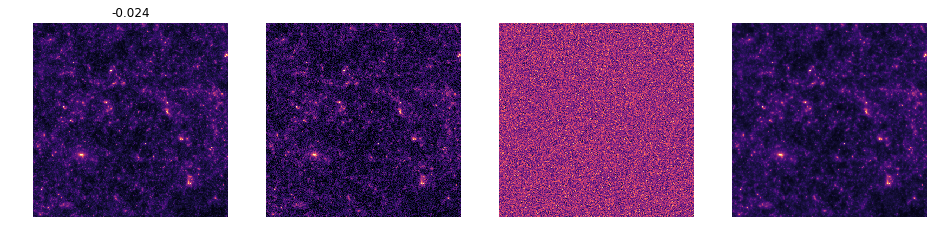

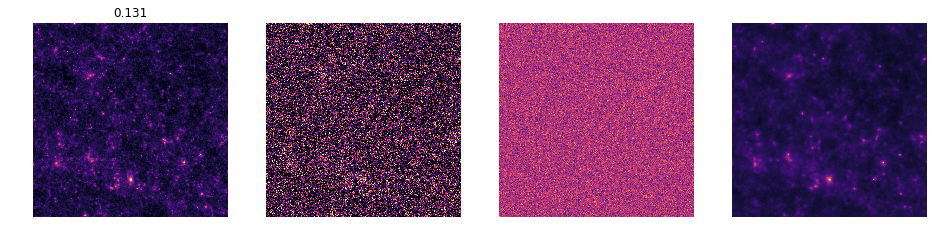

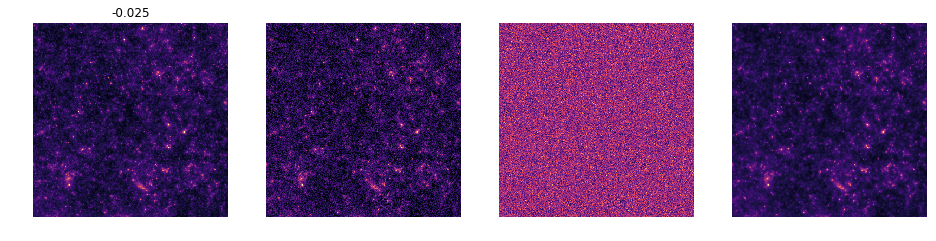

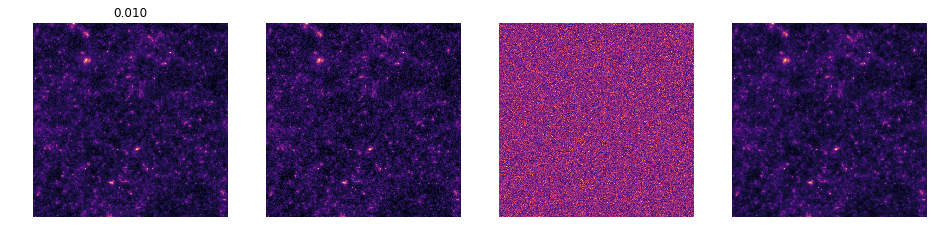

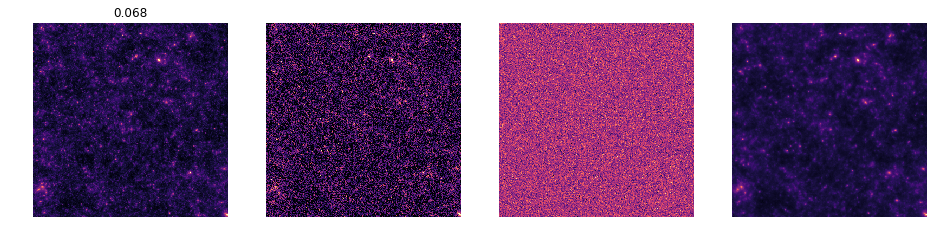

In [10]:
batch = next(train_set)
#res, state = score_fn(batch['x'],batch['s'], is_training=False)
_, res, gaussian_score = score_fn(batch)

for i in range(5):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    #imshow(res[ind,...,0],cmap='magma')
    imshow(res[ind,...,0] + gaussian_score[ind,...,0], cmap='magma')
    axis('off')
    #title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
    subplot(144)
    #imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    #batch['s'] * (res + gaussian_score))**2
    axis('off')

In [11]:
#, res, g = score_fn(batch)
x = batch['x']
y = batch['y']
s = batch['s']
u = batch['u']
net_input = {"y":x, "s":s}
_, res, g = score_fn(net_input)
res

DeviceArray([[[[-7.10799754e-01, -7.10799754e-01],
               [-6.72594547e+00, -6.72594547e+00],
               [-1.02032681e+01, -1.02032681e+01],
               ...,
               [-3.63544083e+00, -3.63544083e+00],
               [-4.15058613e+00, -4.15058613e+00],
               [-2.71848345e+00, -2.71848345e+00]],

              [[-5.95511103e+00, -5.95511103e+00],
               [ 3.59849262e+00,  3.59849262e+00],
               [-1.04140568e+00, -1.04140568e+00],
               ...,
               [-3.67412972e+00, -3.67412972e+00],
               [-5.19552660e+00, -5.19552660e+00],
               [-2.04895377e+00, -2.04895377e+00]],

              [[-9.71371460e+00, -9.71371460e+00],
               [-4.99681425e+00, -4.99681425e+00],
               [-1.19774759e+00, -1.19774759e+00],
               ...,
               [-1.73219776e+00, -1.73219776e+00],
               [-4.24893761e+00, -4.24893761e+00],
               [-3.95931911e+00, -3.95931911e+00]],

              ..

## MAP

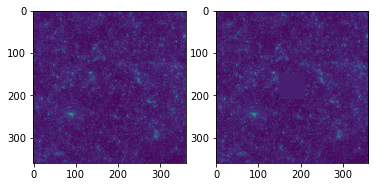

In [12]:
x = batch['x']
mask = np.ones_like(x[0:1])
mask[:, 150:210, 150:210] = 0
x_masked = np.copy(x[0:1]) * mask
subplot(121)
imshow(x[0,...,0])
subplot(122)
imshow(x_masked[0,...,0])

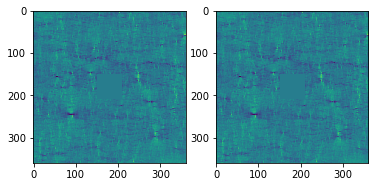

In [13]:
# Shear
mask = mask.reshape((360,360))

kE = x[0,...,0]
kB = jnp.zeros_like(kE)
g1, g2 = ks93inv(kE, kB)
masked_g1 = g1 * mask
masked_g2 = g2 * mask

subplot(121)
imshow(masked_g1)
subplot(122)
imshow(masked_g1)

true_shear = jnp.stack([masked_g1, masked_g2], axis=0).flatten()

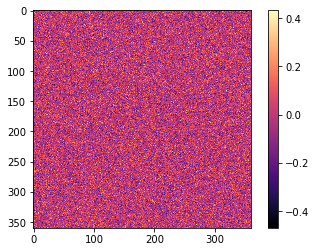

In [14]:
temp = 1e-4
sigma = jnp.ones((1,1)) * temp

init_image=(0.1*randn(1,360,360)).reshape((-1, 360*360)).astype('float32')

imshow(init_image.reshape((360,360)), cmap='magma')
colorbar()

In [15]:
# likelihood score
def likelihood_fn(x, sigma):
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros_like(ke)
    gamma1, gamma2 = ks93inv(ke, kb)
    masked_gamma1, masked_gamma2 = (mask.reshape((map_size, map_size))*gamma1,
                                    gamma2*mask.reshape((map_size, map_size)))
    shear = jnp.stack([masked_gamma1, masked_gamma2], axis=0).flatten()
    return jnp.sum( ((shear-true_shear)/(1e-2 + sigma))**2 )/2.

score_likelihood = jax.vmap(jax.grad(likelihood_fn))

In [16]:
score_likelihood(init_image, sigma).shape

(1, 129600)

In [17]:
net_input = {'y':init_image.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
_, res, gaussian_score = score_fn(net_input)
print((res[..., 0:1] + gaussian_score).shape)

(1, 360, 360, 1)


In [18]:
score_lh = score_likelihood(init_image, sigma).reshape(1, 360, 360, 1)

net_input = {'y':init_image.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
_, res, gaussian_score = score_fn(net_input)
score_p = res[..., 0:1] + gaussian_score

(score_lh + score_p).shape

(1, 360, 360, 1)

In [19]:
eps = 1e-5
sigma = np.ones(1) * temp

@jax.jit
def update(x_old):
    # prior score
    net_input = {'y':x_old.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
    _, res, gaussian_score = score_fn(net_input)
    score_p = res[..., 0:1] + gaussian_score
    # likelihood score
    score_lh = score_likelihood(x_old, sigma).reshape(1, 360, 360, 1)
    
    score_post = - score_lh + score_p
    
    x_new = x_old + eps * score_post.reshape(-1, 360*360)
    return x_new

x_new = update(init_image)

In [20]:
x_old = init_image.copy()
for i in range(100):
    x_new = update(x_old)
    x_old = x_new

Text(0.5,1,'MAP')

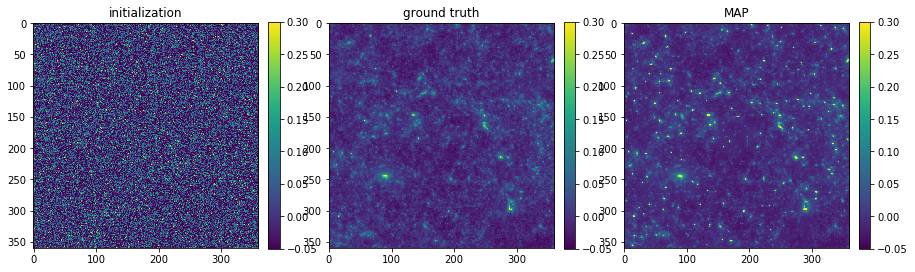

In [21]:
figure(figsize=(15,5))

subplot(131)
imshow(init_image.reshape(360, 360), vmin=-0.05,vmax=0.3)
colorbar(fraction=0.046, pad=0.04)
title('initialization')

subplot(132)
imshow(x[0,...,0].reshape(360, 360), vmin=-0.05,vmax=0.3)
colorbar(fraction=0.046, pad=0.04)
title('ground truth')

subplot(133)
imshow(x_new.reshape(360, 360), vmin=-0.05,vmax=0.3)
colorbar(fraction=0.046, pad=0.04)
title('MAP')